In [40]:
%matplotlib inline
import tensorflow as tf
import numpy as np
#from plotly.graph_objs import Scatter, Layout 
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from scipy.spatial.distance import directed_hausdorff
import sklearn.metrics
import scipy

In [140]:
#https://github.com/martinkersner/py_img_seg_eval/blob/master/eval_segm.py
#https://github.com/MaxwellRebo/ittk/blob/master/ittk/main.py
def variation_of_information(X, Y):
    n = float(sum([len(x) for x in X]))
    sigma = 0.0
    for x in X:
        p = len(x) / n
    for y in Y:
        q = len(y) / n
        r = len(set(x) & set(y)) / n
        if r > 0.0:
            sigma += r * (np.math.log(r / p, 2) + np.math.log(r / q, 2))
    return abs(sigma)

def information_variation(x, y):
    """
    :param x:
     List or numpy array
    :param y:
     List or numpy array
    :return:
     Float: the information variation of x and y
    """
    x = check_numpy_array(x)
    y = check_numpy_array(y)
    return entropy(x) + entropy(y) - (2 * mutual_information(x, y))

def check_prob_sum(arr):
    return int(sum(arr)) == 1


def entropy(x):
    x = probs(x)
    total = 0
    for x_i in x:
        if x_i == 0:
            continue
        total -= x_i * np.log2(x_i)
    return total


def mutual_information(x, y, normalized=False, base=2):
    """
    Compute the mutual information between two sets of observations.
    First converts observations to discrete conditional probability distribution, then computes their MI.
    :param x:
     List or numpy array.
    :param y:
     List or numpy array.
    :param normalized:
     Normalize the inputs. Defaults to False.
    :param base:
     The log base used in the MI calculation. Defaults to 2.
    :return:
     Float: the mutual information between x and y.
    """
    x = check_numpy_array(x)
    y = check_numpy_array(y)
    numobs = len(x)
    if numobs != len(y):
        raise Exception("Inputs not of matching length")
    mutual_info = 0.0
    uniq_x = set(x)
    uniq_y = set(y)
    for _x in uniq_x:
        for _y in uniq_y:
            px = np.shape(np.where(x == _x))[1] / numobs
            py = np.shape(np.where(y == _y))[1] / numobs
            pxy = len(np.where(np.in1d(np.where(x == _x)[0],
                                 np.where(y == _y)[0]) == True)[0]) / numobs
            if pxy > 0.0:
                mutual_info += pxy * math.log((pxy / (px * py)), base)
    if normalized: mutual_info = mutual_info / np.log2(numobs)
    return mutual_info


def intersection_over_union(image1,image2):
    intersection = np.sum(np.logical_and(image1,image2))
    union = np.sum(np.logical_or(image1,image2))
    return float(intersection)/(union + 0.1)

def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''
    check_size(eval_segm, gt_segm)
    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)
    sum_n_ii = 0
    sum_t_i  = 0
    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i
    return pixel_accuracy_

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise
    return height, width


def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)
    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))
    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c
    return masks

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)
    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

def dice(image1,image2):
    intersection = np.sum(np.logical_and(image1,image2))
    union = np.sum(np.logical_or(image1,image2))
    jac = float(intersection)/union
    return 2*jac/(1+jac)

def recall(image1,image2):
    m = sklearn.metrics.confusion_matrix(image1.reshape(900,1),image2.reshape(900,1))
    tp = 0
    for i in range(m.shape[0]):
        tp = tp+ m[i,i]
    fn = np.sum(np.triu(m, k=1))
    fp = np.sum(np.tril(m, k=-1))
    return float(tp)/float(tp+fn)

def precision(image1,image2):
    m = sklearn.metrics.confusion_matrix(image1.reshape(900,1),image2.reshape(900,1))
    tp = 0
    for i in range(m.shape[0]):
        tp = tp+ m[i,i]
    fn = np.sum(np.triu(m, k=1))
    fp = np.sum(np.tril(m, k=-1))
    return float(tp)/float(tp+fp)

def volumetric_similarity(image1,image2):
    m = sklearn.metrics.confusion_matrix(image1.reshape(900,1),image2.reshape(900,1))
    tp = 0
    for i in range(m.shape[0]):
        tp = tp+ m[i,i]
    fn = np.sum(np.triu(m, k=1))
    fp = np.sum(np.tril(m, k=-1))
    return 1 - float(fn - fp)/(2*tp + fp + fn)

def relative_volume_distance(image1,image2):
    m = sklearn.metrics.confusion_matrix(image1.reshape(900,1),image2.reshape(900,1))
    tp = 0
    for i in range(m.shape[0]):
        tp = tp+ m[i,i]
    fn = np.sum(np.triu(m, k=1))
    fp = np.sum(np.tril(m, k=-1))
    return 1 - float(fn - fp)/(2*tp + fp + fn)

def volume_ratio(image1,image2):
    return float(np.sum(image1))/np.sum(image2)


def mean_intersection_over_union(image1,image2,labels):
    '''
    example labels in the image labels = [0,1,2]
    exclude background when passing
    '''
    #labels = np.unique(image2)
    ious = []
    for label in labels:
        binary_image1 = image1 == label
        binary_image2 = image2 == label
        iou = intersection_over_union(binary_image1,binary_image2)
        ious.append(iou)
    return np.sum(ious)/(len(ious)+0.1)

def object_level_consistency_v1(truth,clustering):
    '''
    coded following polak, zhang and pi, 2009
    M is labels in truth j index per paper
    N is labels in clustering i index per paper
    '''
    labels = np.unique(truth)
    labelsC = np.unique(clustering)
    ious = []
    wijd = []
    iouI = []
    for j in labels:
        iouI = []
        binary_image1 = truth == j
        for i in labelsC:
            binary_image3 = clustering==i
            iou1 = intersection_over_union(binary_image1,binary_image3)
            wijd = []
            for k in labelsC:
                binary_image4 = clustering==k
                wijd1 = 1.0*(np.sum(np.logical_and(binary_image1,binary_image4)))*len(binary_image4)
                wijd.append(wijd1)
            wij = 1.0*(np.sum(np.logical_and(binary_image1,binary_image3))*len(binary_image3))/sum(wijd)    
            iouI.append(iou1*wij)
        iou= float(np.sum(iouI))     
        wj = 1.0*len(binary_image1)/len(truth)
        OCE = (1.0-iou)*wj
        ious.append(OCE)
    number_of_classes = max(1.0*len(labels)/len(labelsC), 1.0*len(labelsC)/len(labels))
    # oversegm penalty
    return (np.sum(ious))*number_of_classes/len(labels)

def object_level_consistency(truth,clustering):
    '''
    coded following polak, zhang and pi, 2009
    M is labels in truth j index per paper
    N is labels in clustering i index per paper
    it does not correct for missed objects
    '''
    labels = np.unique(truth)
    labelsC = np.unique(clustering)
    wijdT = []
    iouIT = []
    iousT = []
    for j in labels:
        iouIT = []
        binary_image1 = truth == j
        for i in labelsC:
            binary_image3 = clustering==i
            iou1 = intersection_over_union(binary_image1,binary_image3)
            wijd = []
            for k in labelsC:
                binary_image4 = clustering==k
                wijd1 = 1.0*(np.sum(np.logical_and(binary_image1,binary_image4)))*len(binary_image4)
                wijd.append(wijd1)
            wij = 1.0*(np.sum(np.logical_and(binary_image1,binary_image3))*len(binary_image3))/(sum(wijd)+0.1)    
            iouIT.append(iou1*wij)
        iou= float(np.sum(iouIT))     
        wj = 1.0*len(binary_image1)/len(truth)
        OCE = (1.0-iou)*wj
        iousT.append(OCE)
        wijdT = []
    iouIC = []
    iousC = []
    for j in labelsC:
        iouIC = []
        binary_image1 = truth == j
        for i in labels:
            binary_image3 = clustering==i
            iou1 = intersection_over_union(binary_image1,binary_image3)
            wijd = []
            for k in labels:
                binary_image4 = clustering==k
                wijd1 = 1.0*(np.sum(np.logical_and(binary_image1,binary_image4)))*len(binary_image4)
                wijd.append(wijd1)
            wij = 1.0*(np.sum(np.logical_and(binary_image1,binary_image3))*len(binary_image3))/(sum(wijd)+0.1)    
            iouIC.append(iou1*wij)
        iou= float(np.sum(iouIC))     
        wj = 1.0*len(binary_image1)/len(truth)
        OCE = (1.0-iou)*wj
        iousC.append(OCE)

    number_of_classes = min(1.0*len(labels)/len(labelsC), 1.0*len(labelsC)/len(labels))
    # oversegm penalty
    if (len(labelsC)>len(labels)):
        oversegm = 1.0*len(labelsC)/len(labels)
        undersegm = 1.0
    else:
        undersegm = 1.0*len(labels)/len(labelsC)
        oversegm = 1.0
    return round(max(np.mean(iousC),np.mean(iousT)),3)



import numpy as np
from scipy.misc import comb

def rand_index(clusters, classes):
    '''
    Probabilistic RI - Average the result accross all human segmentations of a given image - we do not have more than 1
    '''
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    RI =  (tp + tn) / (tp + fp + fn + tn)
    return RI

def print_function(ground_truth, case, labels =[1,2,4] ):
    print("MIoU  "+ str(round(mean_intersection_over_union(ground_truth,case,labels),2))
    ,"Dice  "+ str(dice(ground_truth,case)) 
    ,"Recall  "+ str(recall(ground_truth,case))
    ,"Precision  "+ str(precision(ground_truth,case))
    ,"OCE  " + str(object_level_consistency(ground_truth, case))
    ,"pixel_accuracy  " + str(pixel_accuracy(ground_truth, case))
    ,"volumetric_similarity  " + str(volumetric_similarity(ground_truth, case))   
    ,"AdjRand " + str(round(sklearn.metrics.adjusted_rand_score(ground_truth.reshape(30*30), case.reshape(30*30)),2))      
    ,"Mut Info " + str(round(sklearn.metrics.adjusted_mutual_info_score(ground_truth.reshape(30*30), case.reshape(30*30)),2))
    ,"VI  " +  str(round(information_variation(ground_truth.reshape(900), case.reshape(900)),2))
    ,"InterClassCor " + str(round(scipy.stats.pearsonr(ground_truth.reshape(900), case.reshape(900))[0],2))
    ,"Wasserstein " + str(round(scipy.stats.wasserstein_distance(ground_truth.reshape(30*30), case.reshape(30*30)),2))      
    ,"HausD  " + str(round(directed_hausdorff(ground_truth, case)[0],2))     
         )

In [128]:
### generate ground truth
ground_truth = np.zeros((30,30), dtype=int)
box1 = np.array([1]*5*5).reshape(5,5)
box2 = np.array([2]*5*5).reshape(5,5)
box3 = np.array([4]*5*5).reshape(5,5)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
ground_truth[x:x+5, y:y+5] = box1
ground_truth[x+5:x+10, y+5:y+10] = box1
ground_truth[x+15:x+20, y+15:y+20] = box2
ground_truth[x+24:x+29, y:y+5] = box3

('MIoU  0.96', 'Dice  1.0', 'Recall  1.0', 'Precision  1.0', 'OCE  0.003', 'pixel_accuracy  1.0', 'volumetric_similarity  1.0', 'AdjRand 1.0', 'Mut Info 1.0', 'VI  1.34', 'InterClassCor 1.0', 'Wasserstein 0.0', 'HausD  0.0')


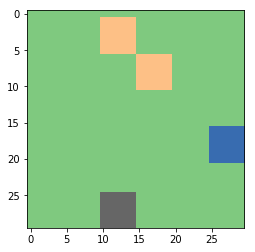

In [141]:
plt.imshow(ground_truth, cmap='Accent');
print_function(ground_truth,ground_truth)

('MIoU  0.16', 'Dice  1.0', 'Recall  1.0', 'Precision  0.944444444444', 'OCE  0.5', 'pixel_accuracy  0.9444444444444444', 'volumetric_similarity  1.02857142857', 'AdjRand 0.98', 'Mut Info 0.75', 'VI  1.17', 'InterClassCor 0.84', 'Wasserstein 0.11', 'HausD  6.71')


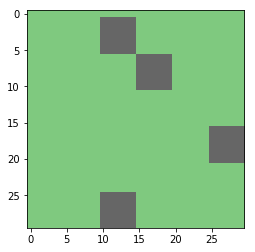

In [142]:
### generate case1 under segmentation
case1 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*5*5).reshape(5,5)
box2 = np.array([2]*5*5).reshape(5,5)
box3 = np.array([4]*5*5).reshape(5,5)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
case1[x:x+5, y:y+5] = box1
case1[x+5:x+10, y+5:y+10] = box1
case1[x+15:x+20, y+15:y+20] = box1
case1[x+24:x+29, y:y+5] = box1
plt.imshow(case1, cmap='Accent');
print_function(ground_truth,case1)

('MIoU  0.09', 'Dice  0.3', 'Recall  0.906024096386', 'Precision  0.914841849148', 'OCE  0.754', 'pixel_accuracy  0.8355555555555556', 'volumetric_similarity  0.995157384988', 'AdjRand 0.19', 'Mut Info 0.12', 'VI  1.34', 'InterClassCor 0.02', 'Wasserstein 0.0', 'HausD  7.81')


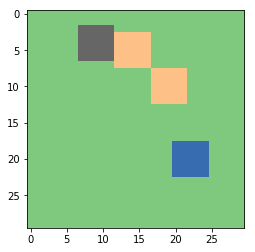

In [143]:
### case2 - categories correct spatially air as object
case2 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*5*5).reshape(5,5)
box2 = np.array([2]*5*5).reshape(5,5)
box3 = np.array([4]*5*5).reshape(5,5)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
case2[x+2:x+7, y+2:y+7] = box1
case2[x+7:x+12, y+7:y+12] = box1
case2[x+17:x+22, y+10:y+15] = box2
case2[x+1:x+6, y-3:y+2] = box3
plt.imshow(case2, cmap='Accent');
print_function(ground_truth,case2)

('MIoU  0.8', 'Dice  0.857142857143', 'Recall  1.0', 'Precision  0.972222222222', 'OCE  0.194', 'pixel_accuracy  0.9722222222222222', 'volumetric_similarity  1.01408450704', 'AdjRand 0.83', 'Mut Info 0.73', 'VI  1.22', 'InterClassCor 0.98', 'Wasserstein 0.03', 'HausD  2.24')


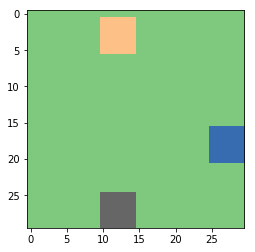

In [144]:
### case3 - less categories spacially correct missed objects
case3 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*5*5).reshape(5,5)
box2 = np.array([2]*5*5).reshape(5,5)
box3 = np.array([4]*5*5).reshape(5,5)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
case3[x:x+5, y:y+5] = box1
#case3[x+5:x+10, y+5:y+10] = box1
case3[x+15:x+20, y+15:y+20] = box2
case3[x+24:x+29, y:y+5] = box3
plt.imshow(case3, cmap='Accent');
print_function(ground_truth,case3)

('MIoU  0.5', 'Dice  0.689655172414', 'Recall  0.9', 'Precision  1.0', 'OCE  0.412', 'pixel_accuracy  0.9', 'volumetric_similarity  0.947368421053', 'AdjRand 0.59', 'Mut Info 0.43', 'VI  1.73', 'InterClassCor 0.69', 'Wasserstein 0.21', 'HausD  5.66')


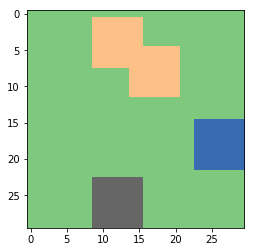

In [145]:
### case4 - detected materials larger 
case4 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*7*7).reshape(7,7)
box2 = np.array([2]*7*7).reshape(7,7)
box3 = np.array([4]*7*7).reshape(7,7)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
case4[x:x+7, y-1:y+6] = box1
case4[x+4:x+11, y+4:y+11] = box1
case4[x+14:x+21, y+13:y+20] = box2
case4[x+22:x+29, y-1:y+6] = box3
plt.imshow(case4, cmap='Accent');
print_function(ground_truth,case4)

('MIoU  0.08', 'Dice  0.205882352941', 'Recall  0.972972972973', 'Precision  0.902050113895', 'OCE  0.747', 'pixel_accuracy  0.88', 'volumetric_similarity  1.0378250591', 'AdjRand 0.14', 'Mut Info 0.07', 'VI  0.97', 'InterClassCor -0.01', 'Wasserstein 0.14', 'HausD  5.66')


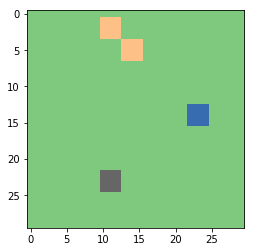

In [146]:
### case5 - detected materials smaller
case5 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*3*3).reshape(3,3)
box2 = np.array([2]*3*3).reshape(3,3)
box3 = np.array([4]*3*3).reshape(3,3)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
case5[x:x+3, y:y+3] = box1
case5[x+3:x+6, y+3:y+6] = box1
case5[x+12:x+15, y+12:y+15] = box2
case5[x+21:x+24, y:y+3] = box3
plt.imshow(case5, cmap='Accent');
print_function(ground_truth,case5)

('MIoU  0.8', 'Dice  1.0', 'Recall  0.972222222222', 'Precision  1.0', 'OCE  0.302', 'pixel_accuracy  0.9722222222222222', 'volumetric_similarity  0.985915492958', 'AdjRand 1.0', 'Mut Info 0.92', 'VI  1.4', 'InterClassCor 0.64', 'Wasserstein 0.19', 'HausD  2.24')


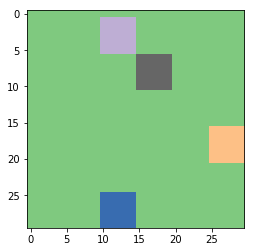

In [147]:
### case6 - additional class oversegmentation
case6 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*5*5).reshape(5,5)
box2 = np.array([2]*5*5).reshape(5,5)
box3 = np.array([4]*5*5).reshape(5,5)
box4 = np.array([8]*5*5).reshape(5,5)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
case6[x:x+5, y:y+5] = box1
case6[x+5:x+10, y+5:y+10] = box4
case6[x+15:x+20, y+15:y+20] = box2
case6[x+24:x+29, y:y+5] = box3
plt.imshow(case6, cmap='Accent');
print_function(ground_truth,case6)

('MIoU  0.8', 'Dice  0.727272727273', 'Recall  0.888888888889', 'Precision  1.0', 'OCE  0.434', 'pixel_accuracy  0.8888888888888888', 'volumetric_similarity  0.941176470588', 'AdjRand 0.67', 'Mut Info 0.59', 'VI  1.79', 'InterClassCor 0.21', 'Wasserstein 1.11', 'HausD  6.71')


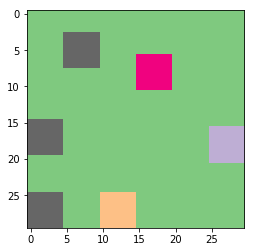

In [148]:
### case7 - additional class oversegmentation
case7 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*5*5).reshape(5,5)
box2 = np.array([2]*5*5).reshape(5,5)
box3 = np.array([4]*5*5).reshape(5,5)
box4 = np.array([8]*5*5).reshape(5,5)
box5 = np.array([11]*5*5).reshape(5,5)
box6 = np.array([12]*5*5).reshape(5,5)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image 
case7[x:x+5, y:y+5] = box1
case7[x+5:x+10, y+5:y+10] = box4
case7[x+15:x+20, y+15:y+20] = box2
case7[x+24:x+29, y:y+5] = box3
case7[3:8, 5:10] = box5
case7[25:30, 0:5] = box5
case7[15:20, 0:5] = box5

plt.imshow(case7, cmap='Accent');
print_function(ground_truth,case7)

('MIoU  0.41', 'Dice  0.489913544669', 'Recall  0.785310734463', 'Precision  0.978873239437', 'OCE  0.685', 'pixel_accuracy  0.7722222222222223', 'volumetric_similarity  0.890282131661', 'AdjRand 0.36', 'Mut Info 0.27', 'VI  2.1', 'InterClassCor 0.05', 'Wasserstein 1.69', 'HausD  4.47')


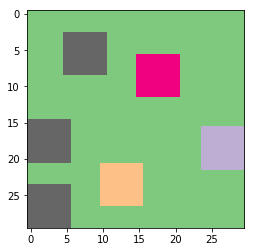

In [150]:
### case8 - additional class oversegmentation + larger images
case8 = np.zeros((30,30), dtype=int)
box1 = np.array([1]*6*6).reshape(6,6)
box2 = np.array([2]*6*6).reshape(6,6)
box3 = np.array([4]*6*6).reshape(6,6)
box4 = np.array([8]*6*6).reshape(6,6)
box5 = np.array([11]*6*6).reshape(6,6)
box6 = np.array([12]*6*6).reshape(6,6)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image 
case8[x:x+6, y:y+6] = box1
case8[x+5:x+11, y+5:y+11] = box4
case8[x+15:x+21, y+14:y+22] = box2
case8[x+20:x+26, y:y+6] = box3
case8[3:9, 5:11] = box5
case8[24:30, 0:6] = box5
case8[15:21, 0:6] = box5

plt.imshow(case8, cmap='Accent');
print_function(ground_truth,case8)

('MIoU  0.64', 'Dice  1.0', 'Recall  1.0', 'Precision  1.0', 'OCE  0.002', 'pixel_accuracy  1.0', 'volumetric_similarity  1.0', 'AdjRand 1.0', 'Mut Info 1.0', 'VI  0.33', 'InterClassCor 1.0', 'Wasserstein 0.0', 'HausD  0.0')


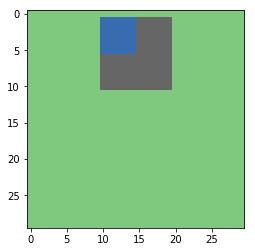

In [104]:
### generate ground truth - nested 
ground_truth = np.zeros((30,30), dtype=int)
box1 = np.array([1]*5*5).reshape(5,5)
box2 = np.array([2]*10*10).reshape(10,10)
#coordinates
#x, y = np.random.randint(0,30-5, size=2)
x = 1
y = 10
#Replace original image with white box
ground_truth[x:x+10, y:y+10] = box2
ground_truth[x:x+5, y:y+5] = box1
plt.imshow(ground_truth, cmap='Accent');
print_function(ground_truth,ground_truth)

In [ ]:
def variation_of_info (cl1, cl2, parts = FALSE, base = 2): 
    if (len(cl1) != len(cl2)) 
        stop("cl1 and cl2 must have same length")
    def ent(cl): {
        n <- len(cl)
        p <- table(cl)/n
        -sum(p * log(p, base = base))
    }
    mi <- function(cl1, cl2) {
        p12 <- table(cl1, cl2)/length(cl1)
        p1p2 <- outer(table(cl1)/length(cl1), table(cl2)/length(cl2))
        sum(p12[p12 > 0] * log(p12[p12 > 0]/p1p2[p12 > 0], base = base))
    }
    if (!parts) 
        return(ent(cl1) + ent(cl2) - 2 * mi(cl1, cl2))
    ent1 <- ent(cl1)
    ent2 <- ent(cl2)
    mi12 <- mi(cl1, cl2)
    c(vi = ent1 + ent2 - 2 * mi12)
}

In [125]:
## misc helpers load first
def probs(x):
    """
    Computes a discrete probability distribution from a list of observations.
    :param x:
     List or numpy array
    :return:
     List: The probability of each symbol appearing in the observations from x.
    """
    n = len(x)
    num_bins = np.bincount(x)
    p = num_bins / float(n)
    return p


def cond_probs(obs):
    """
    Computes a discrete conditional probability distribution from two lists of observations.
    :param obs:
     An ordered list of observations.
    :return:
     Dict: A discrete conditional probability distribution, represented as a dictionary.
    """
    if type(obs) is str:
        obs = list(obs)
    obs = [str(ob) for ob in obs]
    syms = set(obs)
    counts = {}
    probs_dict = {}
    totals = {}
    for sym in syms:
        totals[sym] = obs.count(sym)
        counts[sym] = {}
        probs_dict[sym] = {}
        for other_sym in syms:
            counts[sym][other_sym] = 0
            probs_dict[sym][other_sym] = 0
    for i in range(len(obs) - 1):
        if obs[i + 1] in counts[obs[i]]:
            counts[obs[i]][obs[i + 1]] += 1
            continue
        counts[obs[i]][obs[i + 1]] = 1
    for sym in syms:
        div = 1 if totals[sym] is 0 else totals[sym]
        for other_sym in syms:
            probs_dict[sym][other_sym] = counts[sym][other_sym] / float(div)
    return probs_dict


def match_arrays(x, y):
    """
    Will add 0's to wichever array is shorter, until it matches the length of the longer array.
    No-op if they are the same length.
    :param x:
     Numpy array
    :param y:
     Numpy array
    :return:
     Numpy array, numpy array
    """
    if len(x) > len(y):
        for i in range(len(x) - len(y)):
            y = np.append(y, 0)
    elif len(y) > len(x):
        for i in range(len(y) - len(x)):
            x = np.append(x, 0)
    return x, y


def check_numpy_array(x):
    """
    Will convert x to a numpy array if it is not one already.
    :param x:
     List or numpy array.
    :return:
     Numpy array, from x.
    """
    return np.array(x)


def num_unique(x):
    """
    Returns the number of unique symbols in list/array
    :param x:
     List or numpy array.
    :return:
     Integer: the number of unique symbols in the list/array.
    """
    return len(set(x))


def bin_match(x, y):
    """
    Checks that number of unique symbols in arrays is the same.
    Examples:
    bin_match([1,2], ['A', 'B'])
    True
    bin_match([5, 6, 7], [1, 1, 4, 4])
    False
    :param x:
     List
    :param y:
     List
    :return:
     Bool
    """
    return num_unique(x) == num_unique(y)


def variable_match(x, y):
    """
    Verifies that observation variables of X and Y are from the same set.
    :param x:
     List.
    :param y:
     List.
    :return:
     Bool
    """
    return set(x) == set(y)

In [123]:
ground_truth.count()

AttributeError: 'numpy.ndarray' object has no attribute 'count'